In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [2]:
df = pickle.load(open('quora_dist.pickle', 'rb'))

In [3]:
training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist']

## learn 4 features

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
clf = SGDClassifier(loss='log')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
        df[training_fields], df['is_duplicate'], test_size=0.2, random_state=42)

In [6]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [7]:
X_test['predict_proba'] = list(clf.predict_proba(X_test))

In [8]:
X_test['predict_proba'] = X_test['predict_proba'].apply(lambda x:x[1])

In [9]:
log_loss(y_test, X_test['predict_proba'])

0.568326964329676

# manual word share rate

In [10]:
train_df = df

<IPython.core.display.Javascript object>


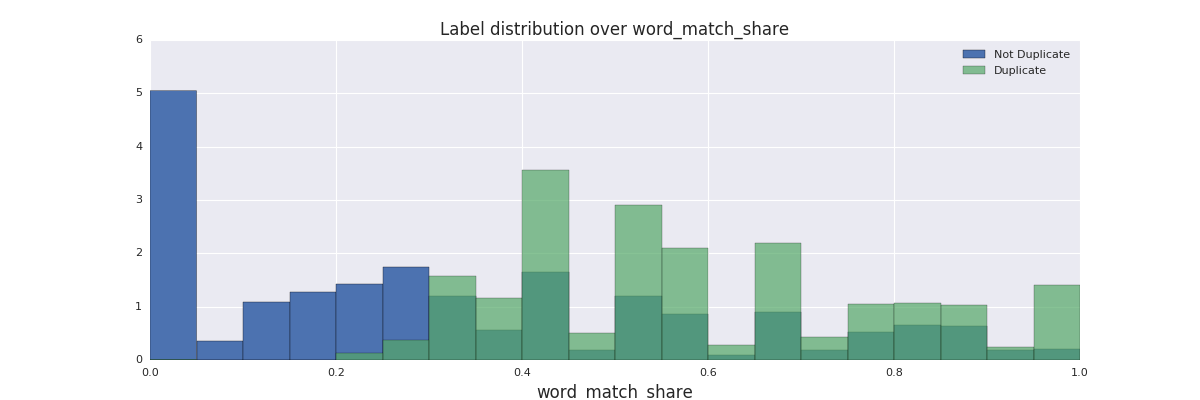

In [11]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))
df_train = train_df

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [12]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [13]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [15]:
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
train_df['word_match'] = train_word_match
train_df['tfidf_word_match'] = tfidf_train_word_match

## doing xgboost - old features

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
        df, df['is_duplicate'], test_size=0.2, random_state=42)

In [18]:
import xgboost as xgb
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

/root/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
#training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist','word_match','tfidf_word_match']
training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist']
#training_fields = ['word_match','tfidf_word_match']

In [20]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.687635	valid-logloss:0.68772
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.642643	valid-logloss:0.643509
[20]	train-logloss:0.610784	valid-logloss:0.612301
[30]	train-logloss:0.587722	valid-logloss:0.589743
[40]	train-logloss:0.57046	valid-logloss:0.572922
[50]	train-logloss:0.557305	valid-logloss:0.560179
[60]	train-logloss:0.547094	valid-logloss:0.550346
[70]	train-logloss:0.539149	valid-logloss:0.542741
[80]	train-logloss:0.532921	valid-logloss:0.536833
[90]	train-logloss:0.527939	valid-logloss:0.532137
[100]	train-logloss:0.523949	valid-logloss:0.528385
[110]	train-logloss:0.52075	valid-logloss:0.525399
[120]	train-logloss:0.518145	valid-logloss:0.522974
[130]	train-logloss:0.516073	valid-logloss:0.521045
[140]	train-logloss:0.514301	valid-logloss:0.519369
[150]	train-logloss:0.51286	valid-logloss:0.518019
[160]	train-logloss:0.511606	val

## doing xgboost - new features

In [21]:
import xgboost as xgb
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

In [22]:
#training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist','word_match','tfidf_word_match']
#training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist']
training_fields = ['word_match','tfidf_word_match']

In [25]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68614	valid-logloss:0.686209
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.629014	valid-logloss:0.629663
[20]	train-logloss:0.588624	valid-logloss:0.589709
[30]	train-logloss:0.559018	valid-logloss:0.560433
[40]	train-logloss:0.536829	valid-logloss:0.538495
[50]	train-logloss:0.519947	valid-logloss:0.521819
[60]	train-logloss:0.50695	valid-logloss:0.50901
[70]	train-logloss:0.496703	valid-logloss:0.49892
[80]	train-logloss:0.488792	valid-logloss:0.49115
[90]	train-logloss:0.482646	valid-logloss:0.485093


## sampling data

In [26]:
sampling_target = 0.175

In [27]:
dup = [len(df[df.is_duplicate==0]),len(df[df.is_duplicate==1])]
dup_rate = 1.0*dup[1]/(dup[0]+dup[1])
print("train duplicate rate: %.3f" % dup_rate)

train duplicate rate: 0.369


In [28]:
target_sample = int(dup[0] * 0.212)
neg_sample = df[df.is_duplicate==1][:target_sample]
pos_sample = df[df.is_duplicate==0]
new_df = pd.concat([neg_sample, pos_sample])

In [30]:
dup = [len(new_df[new_df.is_duplicate==0]),len(new_df[new_df.is_duplicate==1])]
dup_rate = 1.0*dup[1]/(dup[0]+dup[1])
print("train duplicate rate: %.3f" % dup_rate)

train duplicate rate: 0.175


## doing xgboost - again

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
        new_df, new_df['is_duplicate'], test_size=0.2, random_state=42)

In [31]:
import xgboost as xgb
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

In [32]:
#training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist','word_match','tfidf_word_match']
training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist']
#training_fields = ['word_match','tfidf_word_match']

In [35]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683158	valid-logloss:0.683185
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.601867	valid-logloss:0.602137
[20]	train-logloss:0.544926	valid-logloss:0.54539
[30]	train-logloss:0.503829	valid-logloss:0.504451
[40]	train-logloss:0.473508	valid-logloss:0.47424
[50]	train-logloss:0.450858	valid-logloss:0.451712
[60]	train-logloss:0.433835	valid-logloss:0.434825
[70]	train-logloss:0.420843	valid-logloss:0.421908
[80]	train-logloss:0.410851	valid-logloss:0.412002
[90]	train-logloss:0.403083	valid-logloss:0.404321


In [36]:
#training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist','word_match','tfidf_word_match']
#training_fields = ['tf_nonstop_dist','tfidf_nonstop_dist','tfidf_stop_dist','idf_stop_dist']
training_fields = ['word_match','tfidf_word_match']

In [37]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.682642	valid-logloss:0.682682
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.597026	valid-logloss:0.597412
[20]	train-logloss:0.536687	valid-logloss:0.537376
[30]	train-logloss:0.492651	valid-logloss:0.49362
[40]	train-logloss:0.459786	valid-logloss:0.460999
[50]	train-logloss:0.434863	valid-logloss:0.436292
[60]	train-logloss:0.415741	valid-logloss:0.417367
[70]	train-logloss:0.400926	valid-logloss:0.402726
[80]	train-logloss:0.389274	valid-logloss:0.391193
[90]	train-logloss:0.380149	valid-logloss:0.382192


In [ ]:
df = df[['id','is_duplicate','q1_tf_stopwords_vect', 'q2_tf_stopwords_vect', 'q1_tfidf_stopwords_vect', 'q2_tfidf_stopwords_vect']]

In [ ]:
df['tfidf_cos_dist'] = old_df['tfidf_stop_dist']
df['tf_cos_dist'] = old_df['idf_stop_dist']

In [ ]:
df[:3].T

In [ ]:
scq1=df.loc[1,'q1_tf_stopwords_vect']
scq2=df.loc[1,'q2_tf_stopwords_vect']

In [ ]:
def tf_euc_distance(df):
    return euclidean_distances(df.q1_tf_stopwords_vect, df.q2_tf_stopwords_vect)[0]

def tfidf_euc_distance(df):
    return euclidean_distances(df.q1_tfidf_stopwords_vect, df.q2_tfidf_stopwords_vect)[0]

In [ ]:
%time df['tf_euc_dist'] = df.apply(tf_euc_distance, axis=1)['id']

In [ ]:
df['tfidf_euc_dist'] = df['tf_euc_dist']

In [ ]:
df[:3].T

In [ ]:
pickle.dump(df, open('df_stop_vect.pickle', 'wb'))